Zpracovani s XMM SAS
================

- ziskani seznamu pozorovani z [archivu](http://nxsa.esac.esa.int/nxsa-web/#search)
- stazeni a priprava dat
- vyber GTI
- nalezeni zdroje a extrakce spektra

In [1]:
%matplotlib inline 

#stazeni souboru
import sys,os
homedir="/home/limu/data/agn/3C273/"
os.chdir(homedir)
from glob import glob
import pyfits

In [2]:
from numpy import array,r_,argmax,argmin,where,exp,log
olist=[[b[1:-1] for b in a.strip().split(",")] for a in open("list_3C273.obs").readlines()]
olist[0][8]

'OBSERVATION.DURATION'

priprava dat 
---------------

In [3]:
olist=[o for o in olist if o[10]!='Calibration']

In [4]:
durat=array([float(a[8].replace('"','')) for a in olist[1:]])
abest=argmax(durat)
olist[abest+1]

['0159960101',
 '655',
 '2005-01-08 00:00:00.000',
 '187.27785',
 '2.052389',
 '292.54531',
 '2003-07-07 17:40:27.000',
 '2003-07-08 09:56:24.000',
 '58557',
 '3C273',
 'Co-Chandra',
 'Andy',
 'Pollock',
 'QSO RADIO LOUD',
 '289.95106834763743',
 '64.35999164648202',
 '004',
 '00000004_04_cat9.0_20121220.153800',
 '']

In [5]:
olist[0]

['OBSERVATION.OBSERVATION_ID',
 'OBSERVATION.REVOLUTION',
 'OBSERVATION.PROPRIETARY_END_DATE',
 'OBSERVATION.RA_NOM',
 'OBSERVATION.DEC_NOM',
 'OBSERVATION.POSITION_ANGLE',
 'OBSERVATION.START_UTC',
 'OBSERVATION.END_UTC',
 'OBSERVATION.DURATION',
 'OBSERVATION.TARGET',
 'PROPOSAL.TYPE',
 'PROPOSAL.PI_FIRST_NAME',
 'PROPOSAL.PI_SURNAME',
 'TARGET_TYPE.DESCRIPTION',
 'OBSERVATION.LII',
 'OBSERVATION.BII',
 'OBSERVATION.ODF_VERSION',
 'OBSERVATION.PPS_VERSION',
 'OBSERVATION.OBSERVATION_DISTANCE_EQUATORIAL']

In [6]:
durmax=durat[abest]
blist=[olist[i+1][0] for i in where(durat>0.15*durmax)[0]]
blist

['0112771101', '0112770401', '0159960101']

In [7]:
[a for a in os.listdir(".") if a in blist]
#from glob import glob

['0159960101']

In [8]:
sid=blist[-1]
os.mkdir(sid)
sid

FileExistsError: [Errno 17] File exists: '0159960101'

In [9]:
if os.path.exists(sid): os.chdir(sid)
arcaddr="xsa.vilspa.esa.es"
comm="/home/limu/bin/aioclient -S "+arcaddr+" -P 2002 -L 'GET obsno="+sid+" level=ODF'"
os.system(comm)
comm

"/home/limu/bin/aioclient -S xsa.vilspa.esa.es -P 2002 -L 'GET obsno=0159960101 level=ODF'"

In [10]:
ifile=os.listdir(".")[0]
os.system("tar -xzf "+ifile)
os.unlink(ifile)
ifile=glob("*TAR")
if len(ifile)>0:
    os.system("tar -xf "+ifile[0])
    os.unlink(ifile[0])
ifile=os.listdir(".")
"%i souboru"%len(ifile)

'188 souboru'

In [11]:
#initializace HEADAS
os.environ.update({"HEADAS":"/isdc/heasoft-6.16/x86_64-unknown-linux-gnu-libc2.12/"})
scrp=os.popen("/isdc/heasoft-6.16/x86_64-unknown-linux-gnu-libc2.12/BUILD_DIR/headas-setup csh").read().strip()
scomm=open(scrp).readlines()
os.unlink(scrp)
#scomm
slist=[a.strip().replace('"','').split()[1:] for a in scomm]
os.environ.update(dict(slist))

In [12]:
#inicializace SAS - spousti se zatim pri kazdem prikazu
os.environ["SAS_DIR"]="/isdc/xmmsas_20141104_1833"
sas_init=os.environ["SAS_DIR"]+"/sas-setup.sh"

In [14]:
homedir="/home/limu/data/agn/3C273/"
sid='0414190501'
sid='0159960101'
import subprocess as sp
os.chdir(homedir+sid)

In [15]:
sumfile=[a for a in ifile if a[-7:-3]=='SUM.']# or a[-4:]=='SUM.SAS']
if len(sumfile)==0:
    out=os.popen(". "+sas_init+"; odffix").readlines()
    print(len(out))
    sumfile=[a for a in os.listdir(".") if a[-7:-3]=='SUM.']
sumfile[0]

'0655_0159960101_SCX00000SUM.ASC'

processing
-----------------

Postup dle http://galaxytea.blogspot.cz/2010/12/xmm-sas.html

    export SAS_ODF=$PWD
    cifbuild
    export SAS_CCF=${SAS_ODF}/ccf.cif
    odfingest

    epchain
    pn-filter #good time filtering


In [16]:
os.environ["SAS_ODF"]=homedir+"/"+sid
if not (os.path.exists("ccf.cif")):
    out=os.popen(". "+sas_init+"; cifbuild").readlines()
os.environ["SAS_CCF"]=os.environ["SAS_ODF"]+"/ccf.cif"
if len(glob("*SUM.SAS"))==0:
    out=os.popen(". "+sas_init+"; odfingest").readlines()

In [17]:
detype='pn'
try:
    os.mkdir(detype)
    os.chdir(detype)
    out=os.popen(". "+sas_init+"; e"+detype[0]+"chain").readlines()
except:
    print(detype+" exists")
    os.chdir(detype)

pn exists


In [18]:
evtfile=glob(os.environ["SAS_ODF"]+"/"+detype+"/*EVLI*")[-1]
events=pyfits.open(evtfile)
evtfile,events[1].header["NAXIS2"]

('/home/limu/data/agn/3C273//0159960101/pn/P0159960101PNS005PIEVLI0000.FIT',
 3720655)

In [ ]:
#events[1].header

In [ ]:
comm="evselect table="+os.path.basename(evtfile)+" withrateset=yes rateset='sel_rate.lc' timecolumn=TIME "
comm+="timebinsize=100 maketimecolumn=yes expression='#XMMEA_EP && (PI in [10000:12000]) && (PATTERN<=12)'"
if detype=='mos':comm=comm.replace('EA_EP','EA_EM')
#os.popen2(". "+sas_init+"; "+comm).read()

In [ ]:
import subprocess as sp
fcomm=". "+sas_init+"; "+comm
#fcomm=". "+sas_init+"; cd "+os.environ["SAS_ODF"]+"/pn"+";"+comm
rep=sp.Popen(fcomm,shell=True,cwd=os.environ["SAS_ODF"]+"/"+detype,bufsize=1024,stdout=sp.PIPE,stderr=sp.PIPE,close_fds=True)

In [ ]:
print(rep.stdout.read().decode())

In [ ]:
print(rep.stderr.read())

In [ ]:
from matplotlib import pyplot as pl
os.chdir(os.environ["SAS_ODF"]+"/"+detype)
if os.path.exists("sel_rate.lc"):
    rate=pyfits.open("sel_rate.lc")
x=rate[1].data['TIME']#-events[1].header["MJDREF"]
y=rate[1].data['COUNTS']
pl.plot(x,y)

In [ ]:
rate[2].data

In [ ]:
x[0]/86400

In [ ]:
cols=pl.hist(y,r_[10:60:2],alpha=0.4)
pl.xlabel('rate')

cx=(cols[1][:-1]+cols[1][1:])/2.
from numpy import median,log,exp,polyval,polyfit
csel=abs(cx-median(y))<10
cx=cx[csel]
cy=cols[0][csel]
eids=polyfit(cx,log(cy),2)
fcy=exp(polyval(eids,cx))
pl.plot(cx,fcy)

In [ ]:
cmid=-eids[1]/2./eids[0]
from math import sqrt
cmin,cmax=cmid-3*sqrt(-1/2./eids[0]),cmid+3*sqrt(-1/2./eids[0])
cmin,cmax

In [ ]:
lcfile,gtifile="sel_rate.lc","sel_reg.gti"
sevtfile=detype+"_events_filt.fits"
comm="tabgtigen table="+lcfile+" gtiset="+gtifile+" expression=COUNTS.gt.%.3f.and.COUNTS.lt.%.3f"%(cmin,cmax)
comm+=";evselect table="+evtfile+" withfilteredset=true destruct=yes keepfilteroutput=true "
comm+="expression=\"GTI("+gtifile+",TIME)\" filteredset="+sevtfile
cmopen=lambda fcomm:sp.Popen(". "+sas_init+"; "+fcomm,shell=True,cwd=os.environ["SAS_ODF"]+"/"+detype,bufsize=1024,stdout=sp.PIPE,stderr=sp.PIPE,close_fds=True)
if not os.path.exists(gtifile):
    rep=cmopen(comm)
    out=rep.stdout.readlines()
    print(out[-2:])

In [25]:
cmopen=lambda fcomm:sp.Popen(". "+sas_init+"; "+fcomm,shell=True,cwd=os.environ["SAS_ODF"]+"/"+detype,bufsize=1024,stdout=sp.PIPE,stderr=sp.PIPE,close_fds=True)
if comm=='':
    rep=cmopen(comm)
    out=rep.stdout.readlines()
    out[-2:]

In [ ]:
import re
ex=re.finditer("selected (\d+)",str(out[-2]))
int([e.groups()[0] for e in ex][0])/float(events[1].header["NAXIS2"])

tvorba spektra
------------------------------

In [ ]:
imafile="ima2_view.fits"
binsize=10
comm="evselect table="+sevtfile+" withimageset=true xcolumn=DETX ycolumn=DETY imageset="+imafile#+selexpr
comm+=" ximagebinsize=%i yimagebinsize=%i "%(binsize,binsize)
if not os.path.exists(imafile):
    out=cmopen(comm).stdout.readlines()[1:]

In [ ]:
os.chdir(os.environ["SAS_ODF"]+"/"+detype)
idat=pyfits.open(imafile)[0].data
isel=idat[0:400,:]
pl.imshow(log(isel+1),origin='lower')

In [ ]:
pl.plot((isel.mean(0)+1))
xtop=argmax(isel.mean(0))
xtop

In [ ]:
pl.plot(log(isel.mean(1)+1))
ytop=argmax(isel.mean(1))
ytop

In [ ]:
xtop*binsize,ytop*binsize

In [ ]:
from astropy import wcs
w=wcs.WCS(str(pyfits.open(imafile)[0].header))
ximg,yimg=w.wcs_pix2world([[xtop,ytop]],1)[0]
ximg,yimg

In [ ]:
pl.hist(dd['DETY'],30)

#### test tvorby obrazku 

In [ ]:
rad=10
nevt=pyfits.open(sevtfile)
dd=nevt[1].data
sel1=abs(dd['DETX']-ximg)<rad*10
sel2=abs(dd['DETY']-yimg)<rad*10
sum(sel1*sel2)

In [ ]:
ook=pl.hist2d(dd['DETX'],dd['DETY'],[100,100])

In [ ]:
idat.shape

### ted spektrum

In [22]:
# shortcut if skipping some steps
specfile="agn_spec.pha"
sevtfile=detype+"_events_filt.fits"
if os.path.exists(specfile):
    dd=pyfits.open(specfile)
    ximg,yimg=dd[3].data[0][1:3]

In [26]:

maxchannels={'pn':11999,'mos':20479}
rad=11
selexpr=" expression='(FLAG==0) && (PATTERN<=12) && (PI in [300:12000]) && ((DETX,DETY) IN circle(%i,%i,%i))'"%(ximg,yimg,rad*10)
sevtfile=sevtfile.replace("mos_","mos1_")
#specfile="agn_spec.pha"
if os.path.exists(specfile): os.unlink(specfile)
comm="evselect table="+sevtfile+" withspectrumset=true withspecranges=true "
comm+="energycolumn=PI specchannelmin=0 specchannelmax=%i spectralbinsize=15 updateexposure=yes "%(maxchannels[detype])
srcomm=comm+"spectrumset="+specfile+selexpr
if True or not os.path.exists(specfile):
    rep=cmopen(srcomm)
    out=rep.stdout.read()
    print(out.decode().split('\n')[1:])

['evselect:- evselect (evselect-3.62)  [xmmsas_20141104_1833-14.0.0] started:  2015-03-10T11:54:30.000', 'evselect:- selected 975559 rows from the input table.', 'evselect:- evselect (evselect-3.62)  [xmmsas_20141104_1833-14.0.0] ended:    2015-03-10T11:54:33.000', '']


In [27]:
#selexpr2=" ((DETX,DETY) IN circle(%i,%i,%i))'"%(xtop,450,rad*3)
selexpr2=" expression='circle(%i,%i,%i,DETX,DETY)'"%(0,2000,rad*60)
bgcomm=comm+"spectrumset="+specfile.replace("agn","bkg")+selexpr2#" filteredset="+sevtfile+" withfilteredset=yes"
rep=cmopen(bgcomm)
out=rep.stdout.read()
#print('\n'.join([a for a in out.decode().split()[4:] if a.find('filter')>=0]))
print('\n'.join(out.decode().split('\n')[1:]))

evselect:- evselect (evselect-3.62)  [xmmsas_20141104_1833-14.0.0] started:  2015-03-10T11:54:35.000
evselect:- selected 29704 rows from the input table.
evselect:- evselect (evselect-3.62)  [xmmsas_20141104_1833-14.0.0] ended:    2015-03-10T11:54:36.000



In [40]:
dd['DETX'].max()

3141

In [24]:
ximg,yimg=w.wcs_pix2world([[ytop,xtop]],1)[0]
ximg,yimg

(172.5, -50.5)

In [34]:
out=rep.stdout.read()

In [44]:
spc=pyfits.open(specfile)
bkgspc=pyfits.open(specfile.replace("agn","bkg"))
spc[1].data['COUNTS'].sum(),bkgspc[1].data['COUNTS'].sum()

(975559, 29598)

In [45]:
specfile="agn_spec.pha"
spcomm="extendedsource=no badpixlocation="+sevtfile+" detmaptype=psf "
#dataset detmaparray="+detmap
rmcomm="rmfgen spectrumset="+specfile+" rmfset=spec.rmf "+spcomm
arcomm="arfgen spectrumset="+specfile+" arfset=spec.arf withrmfset=yes rmfset=spec.rmf "+spcomm
out=cmopen(rmcomm).stdout.readlines()[1:]
out

[b'rmfgen:- rmfgen (rmfgen-2.2.1)  [xmmsas_20141104_1833-14.0.0] started:  2015-03-09T15:40:41.000\n',
 b'rmfgen:- Opening spectrumset agn_spec.pha...\n',
 b'rmfgen:- Closing spectrumset agn_spec.pha.\n',
 b'rmfgen:- Computing source position from region extent..\n',
 b'rmfgen:- Using a source position in DET coordinates of x=172 y=-50\n',
 b'rmfgen:-  The source position in focal plane coords is  theta=59.6422 phi=3.5129\n',
 b'rmfgen:- Computing detector map bounds from the region selection information stored in the spectrum ...\n',
 b'rmfgen:- detector map binning will be: xbins: 160 ybins: 160\n',
 b'rmfgen:- Constructing a psf detector map with  xmin=62 xmax=282 xbins=160 ymin=-160 ymax=60 ybins=160\n',
 b'rmfgen:- PSF type: 2 [EXTENDED] will be used\n',
 b'rmfgen:-  Creating RmfDataServer...\n',
 b'rmfgen:-  EventGrades:5 PrimeSmallWindow 36 \n',
 b'rmfgen:-  RmfDataServer created ok.\n',
 b'rmfgen:- Opening data set ...\n',
 b'rmfgen:- Opened data set.\n',
 b'rmfgen:- Adding MAT

In [46]:
out=cmopen(arcomm).stdout.readlines()[1:]
out

[b'arfgen:- arfgen (arfgen-1.90.4)  [xmmsas_20141104_1833-14.0.0] started:  2015-03-09T15:42:27.000\n',
 b'arfgen:- Opening spectrumset agn_spec.pha...\n',
 b'arfgen:- Closing spectrumset agn_spec.pha.\n',
 b'arfgen:- Computing source position from region extent..\n',
 b'arfgen:- Using a source position in DET coordinates of x=172 y=-50\n',
 b'arfgen:-  The source position in focal plane coords is  theta=59.6422 phi=3.5129\n',
 b'arfgen:- Computing detector map bounds from the region selection information stored in the spectrum ...\n',
 b'arfgen:- detector map binning will be: xbins: 5 ybins: 5\n',
 b'arfgen:- Constructing a psf detector map with  xmin=62 xmax=282 xbins=5 ymin=-160 ymax=60 ybins=5\n',
 b'arfgen:- PSF type: 3 [ELLBETA] will be used\n',
 b'arfgen:- Opening arfset spec.arf...\n',
 b'arfgen:- WCS info for the columns temp_badcol_arfgen.del:BADPIX04:RAWX and temp_badcol_arfgen.del:BADPIX04:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping\n',
 b'arfgen:- Wri

In [30]:
rmcomm

'rmfgen spectrumset=agn_spec.pha rmfset=spec.rmf extendedsource=no badpixlocation=mos_events_filt.fits detmaptype=psf '

In [67]:
#print(''.join([o.decode() for o in out]))
regcond="CIRCLE(354,383,84,DETX,DETY)"

In [47]:
comm='backscale spectrumset='+specfile+' badpixlocation='+sevtfile
out=cmopen(comm).stdout.readlines()[1:]
out

[b'backscale:- backscale (backscale-1.4.2)  [xmmsas_20141104_1833-14.0.0] started:  2015-03-09T15:42:57.000\n',
 b"backscale:- Executing (routine): arfgen spectrumset=agn_spec.pha rmfset=response.ds withrmfset=no arfset=deletearf.ds detmaptype=flat detmaparray=detmapfile.ds: detxoffset=1200 detyoffset=1200 withdetbounds=no detxbins=1 detybins=1 withdetbins=yes psfenergy=2 filterdss=yes filteredset=filteredpixellist.ds withfilteredset=no sourcecoords=eqpos sourcex=0 sourcey=0 withsourcepos=no extendedsource=yes modeleffarea=no modelquantumeff=no modelfiltertrans=no modelcontamination=yes modelee=no modelootcorr=yes applyxcaladjustment=no eegridfactor=100 withbadpixcorr=yes badpixlocation=pn_events_filt.fits psfmodel=ELLBETA badpixelresolution=2 withbadpixres=no setbackscale=yes keeparfset=no useodfatt=no ignoreoutoffov=yes crossreg_spectrumset='' crossregionarf=no  -w 1 -V 4\n",
 b'backscale:- arfgen (arfgen-1.90.4)  [xmmsas_20141104_1833-14.0.0] started:  2015-03-09T15:42:57.000\n',
 b

In [28]:
comm="specgroup spectrumset="+specfile+" mincounts=25 oversample=3 rmfset=spec.rmf "
comm+="arfset=spec.arf backgndset="+specfile.replace("agn","bkg")+" groupedset="+specfile.replace("spec","grpspec")
out=cmopen(comm).stdout.readlines()[1:]
out

[b'specgroup:- specgroup (specgroup-1.5)  [xmmsas_20141104_1833-14.0.0] started:  2015-03-10T11:55:02.000\n',
 b'specgroup:- Prepared spectrum agn_grpspec.pha with 162 groups\n',
 b'specgroup:- specgroup (specgroup-1.5)  [xmmsas_20141104_1833-14.0.0] ended:    2015-03-10T11:55:02.000\n']

### pileup check

podle navodu [zde](http://xmm.esac.esa.int/sas/current/documentation/threads/epatplot.shtml)

In [52]:
comm="epatplot set="+sevtfile+" plotfile='"+detype+"_filtered_pat.gif' device='/GIF' withqdp='y'"
out=cmopen(comm).stdout.readlines()[1:]
rlin=[len(out)-2]#[i for i in range(len(out)) if out[i].find("fractions")]
out[rlin[-1]+1]

TypeError: can't concat bytes to int

vystup `epatplot`  

!mos_filtered_pat.gif  :  nefunguje jako static file server :-(

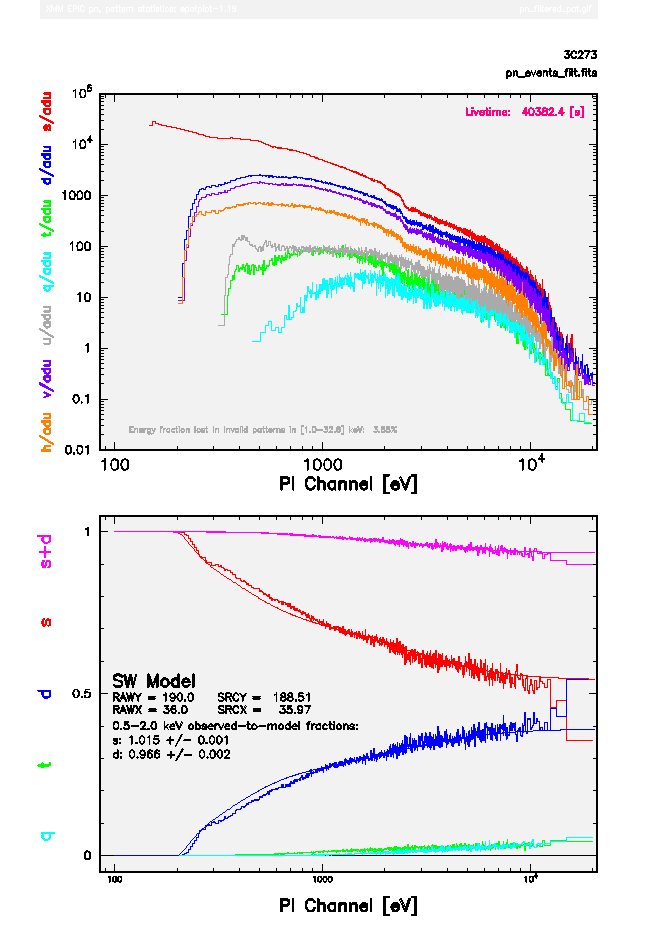

In [55]:
from IPython.display import Image
from PIL import Image as pim
imp=pim.open(os.environ["SAS_ODF"]+"/"+detype+"/"+detype+"_filtered_pat.gif")
#imp=imp.convert('RGB').convert('P', palette=pim.ADAPTIVE)
#bgp = pim.new("RGB", imp.size, (255,255,255))
#bgp.paste(imp,imp)
ofile=os.environ["SAS_ODF"]+"/"+detype+"/"+detype+"_filtered_pat.png"
imp.save(ofile)
Image(filename=ofile)


analyza
--------------

In [26]:
#sys.path.append(os.environ['HEADAS']+"/lib/python")
#del sys.path[-1]
#sys.path.append('/isdc/heasoft-6.16/Xspec/x86_64-unknown-linux-gnu-libc2.12/lib/python')


#import xspec as xs
